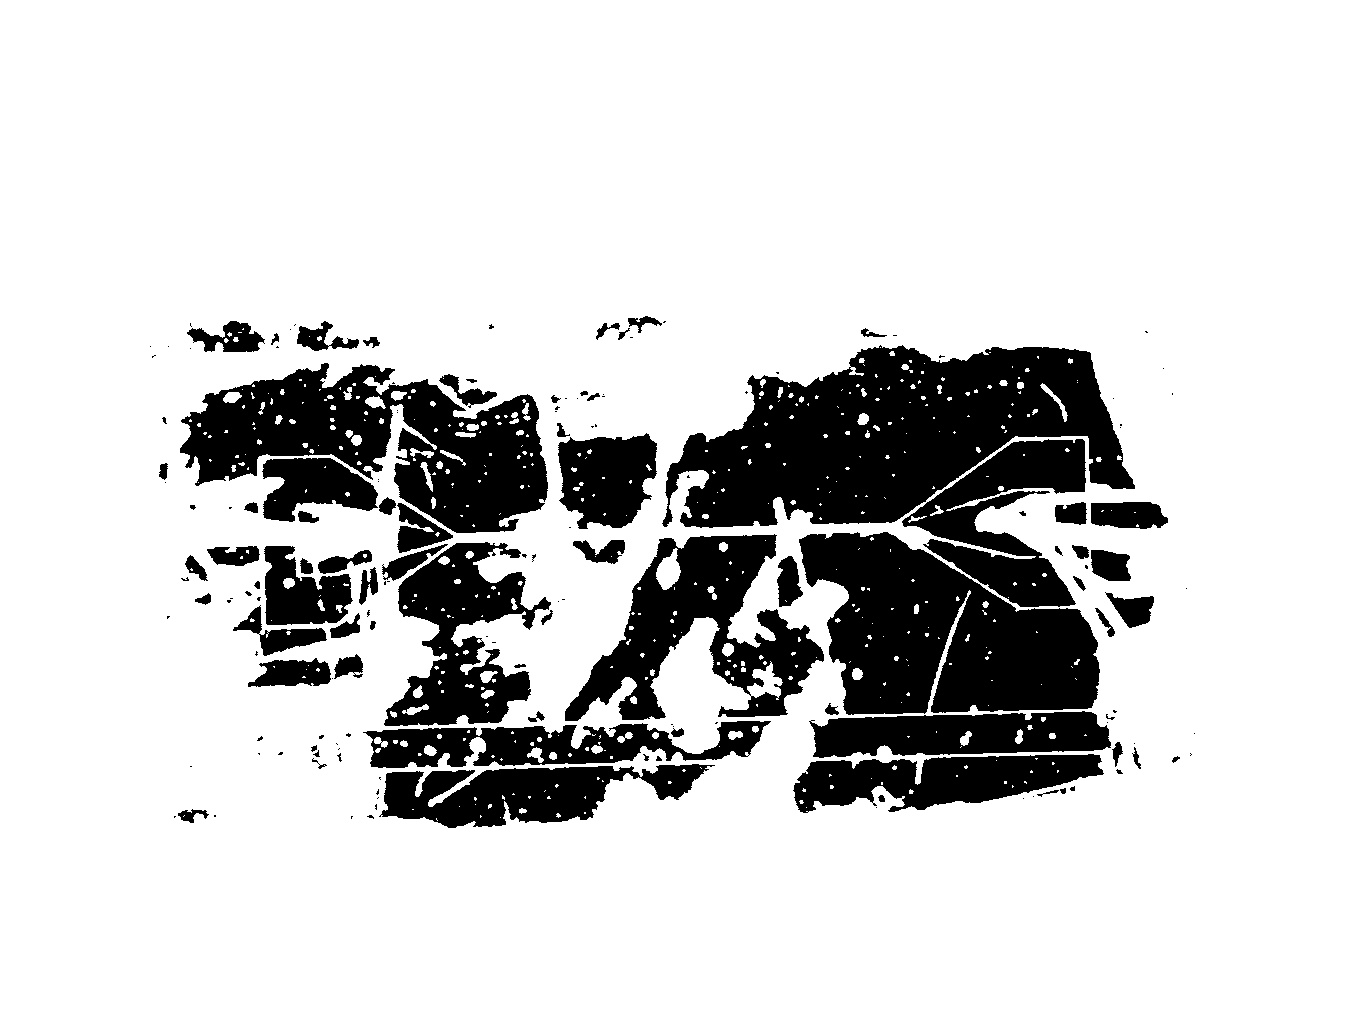

In [107]:
import cv2
import numpy as np
from IPython import display
from matplotlib import pyplot as plt

def imshow(img, format=".jpg", **kwargs):
    """ndarray 配列をインラインで Notebook 上に表示する。"""
    img = cv2.imencode(format, img)[1]
    img = display.Image(img, **kwargs)
    display.display(img)

file_name='images/20250117134627.jpg'
# img=cv2.imread(file_name,cv2.IMREAD_GRAYSCALE)
img=cv2.imread(file_name)
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur=cv2.blur(gray,(1,1))

h,w=gray.shape[:2]
#二値化処理
thresh, gray_thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
imshow(gray_thresh)

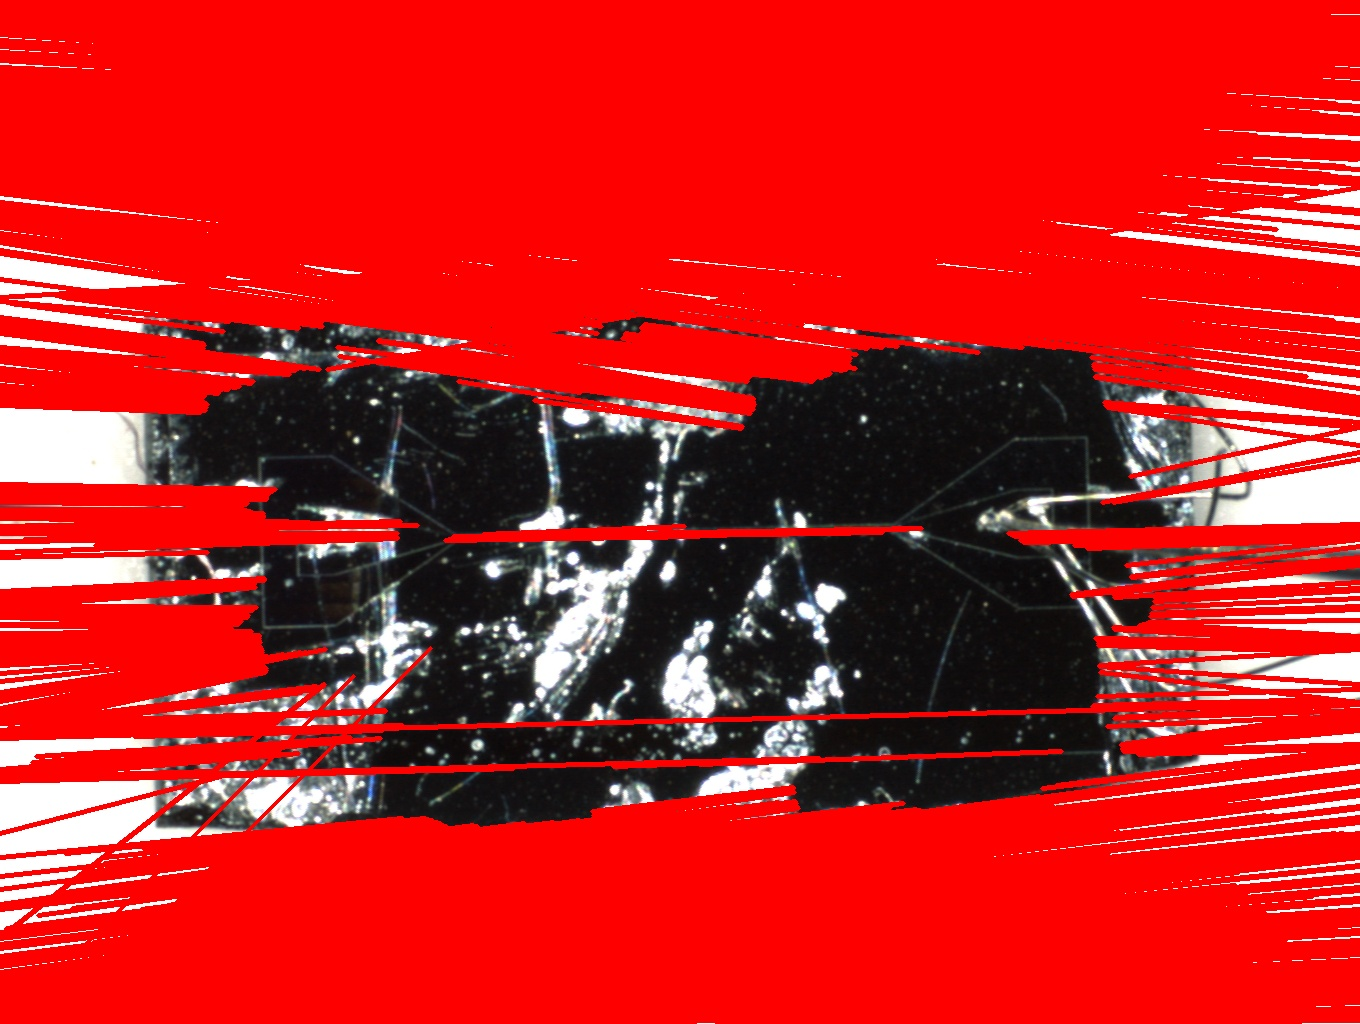

In [108]:
lines = cv2.HoughLinesP(gray_thresh, 
                        rho=1, 
                        theta=np.pi/360, 
                        threshold=80, 
                        minLineLength=200, 
                        maxLineGap=1)

for line in lines:
    x1, y1, x2, y2 = line[0]

    # 赤線を引く
    cv2.line(img, (x1,y1), (x2,y2), (0,0,255), 3)

imshow(img)

In [109]:
#輪郭抽出
contours, hierarchy = cv2.findContours(gray_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours, hierarchy = cv2.findContours(gray_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(contours)

(array([[[   0,    0]],

       [[   0, 1023]],

       [[1359, 1023]],

       [[1359,    0]]], dtype=int32),)


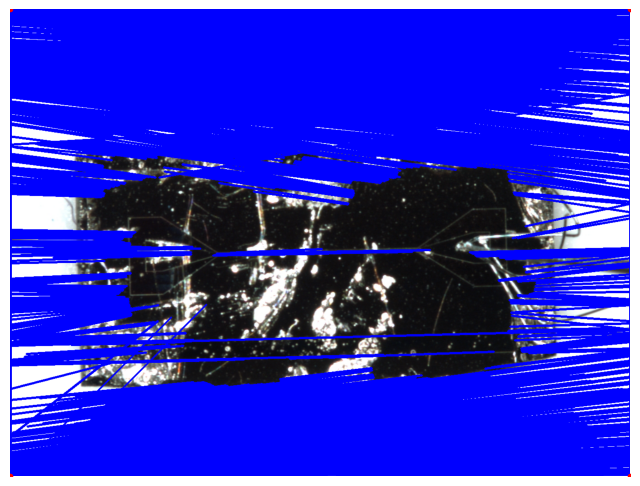

In [110]:
def draw_contours(ax, img, contours):
    ax.imshow(img)
    ax.set_axis_off()

    for i, cnt in enumerate(contours):
        # 形状を変更する。(NumPoints, 1, 2) -> (NumPoints, 2)
        cnt = cnt.squeeze(axis=1)
        # 輪郭の点同士を結ぶ線を描画する。
        ax.add_patch(plt.Polygon(cnt, color="b", fill=None, lw=2))
        # 輪郭の点を描画する。
        ax.plot(cnt[:, 0], cnt[:, 1], "ro", mew=0, ms=4)
        # 輪郭の番号を描画する。
        # ax.text(cnt[0][0], cnt[0][1], i, color="r", size="20", bbox=dict(fc="w"))


fig, ax = plt.subplots(figsize=(8, 8))
draw_contours(ax, img, contours)

plt.show()